In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, GridSearchCV

import warnings
# Ignore warnings
warnings.filterwarnings('ignore')

In [95]:
file_path= 'Datasets\obesity.csv'
data = pd.read_csv(file_path)
data.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


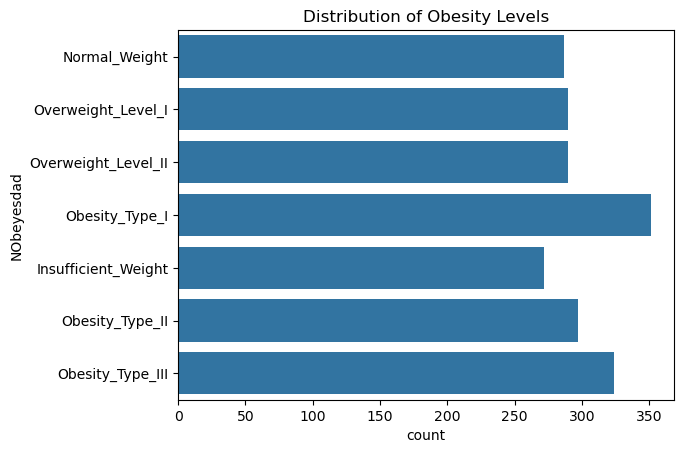

In [24]:
sns.countplot(y='NObeyesdad', data=data)
plt.title('Distribution of Obesity Levels')
plt.show()

In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          2111 non-null   object 
 1   Age                             2111 non-null   float64
 2   Height                          2111 non-null   float64
 3   Weight                          2111 non-null   float64
 4   family_history_with_overweight  2111 non-null   object 
 5   FAVC                            2111 non-null   object 
 6   FCVC                            2111 non-null   float64
 7   NCP                             2111 non-null   float64
 8   CAEC                            2111 non-null   object 
 9   SMOKE                           2111 non-null   object 
 10  CH2O                            2111 non-null   float64
 11  SCC                             2111 non-null   object 
 12  FAF                             21

In [29]:
data.describe()

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
count,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000
mean,24.312600,1.701677,86.586058,2.419043,2.685628,2.008011,1.010298,0.657866
std,6.345968,0.093305,26.191172,0.533927,0.778039,0.612953,0.850592,0.608927
min,14.000000,1.450000,39.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,19.947192,1.630000,65.473343,2.000000,2.658738,1.584812,0.124505,0.000000
50%,22.777890,1.700499,83.000000,2.385502,3.000000,2.000000,1.000000,0.625350
75%,26.000000,1.768464,107.430682,3.000000,3.000000,2.477420,1.666678,1.000000
max,61.000000,1.980000,173.000000,3.000000,4.000000,3.000000,3.000000,2.000000


In [97]:
cont_col = data.select_dtypes(include=['float64']).columns.tolist()

scaler = StandardScaler()
scaled_features = scaler.fit_transform(data[cont_col])

scaled_df = pd.DataFrame(scaled_features, columns=cont_col)
scaled_data = pd.concat([data.drop(columns=cont_col), scaled_df], axis=1)

In [113]:
cat_col = scaled_data.select_dtypes(include=['object']).columns.tolist()
cat_col.remove('NObeyesdad')

encoder = OneHotEncoder(sparse_output=False, drop='first')
encoded_features = encoder.fit_transform(scaled_data[cat_col])

encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(cat_col))
prepped_data = pd.concat([scaled_data.drop(columns=cat_col), encoded_df], axis=1)

prepped_data['NObeyesdad'] = prepped_data['NObeyesdad'].astype('category').cat.codes

In [115]:
prepped_data.head(2)

,NObeyesdad,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE,Gender_Male,...,CAEC_no,SMOKE_yes,SCC_yes,CALC_Frequently,CALC_Sometimes,CALC_no,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
0,1,-0.522124,-0.875589,-0.862558,-0.785019,0.404153,-0.013073,-1.188039,0.561997,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,1,-0.522124,-1.947599,-1.168077,1.088342,0.404153,1.618759,2.339750,-1.080625,0.0,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [144]:
X = prepped_data.drop('NObeyesdad', axis=1)
y = prepped_data['NObeyesdad']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## One-vs-All

In [146]:
model_ova = LogisticRegression(multi_class='ovr', max_iter=1000)
model_ova.fit(X_train, y_train)

LogisticRegression(max_iter=1000, multi_class='ovr')

In [148]:
y_pred_ova = model_ova.predict(X_test)

# Evaluation metrics for OvA
print("One-vs-All (OvA) Strategy Accuracy")
print(np.round(100*accuracy_score(y_test, y_pred_ova),2))

One-vs-All (OvA) Strategy Accuracy
76.12


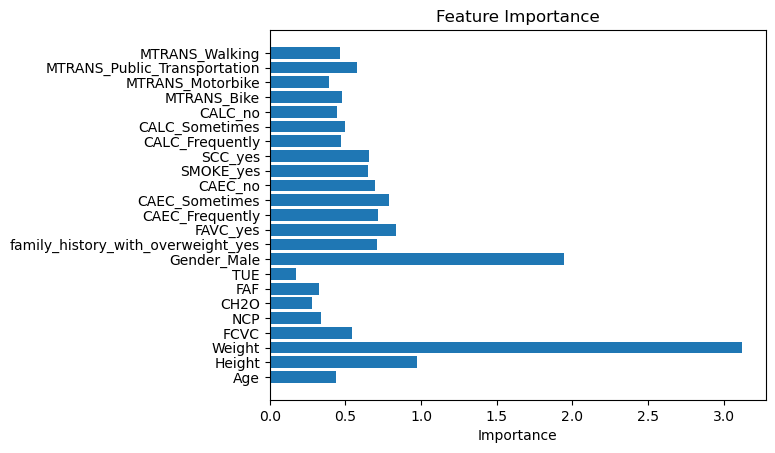

In [181]:
feature_importance = np.mean(np.abs(model_ova.coef_), axis=0)
plt.barh(X.columns, feature_importance)
plt.title("Feature Importance")
plt.xlabel("Importance")
plt.show()

## One-vs-One

In [150]:
model_ovo = OneVsOneClassifier(LogisticRegression(max_iter=1000))
model_ovo.fit(X_train, y_train)

OneVsOneClassifier(estimator=LogisticRegression(max_iter=1000))

In [152]:
y_pred_ovo = model_ovo.predict(X_test)

print("One-vs-One (OvO) Strategy Acuracy")
print(np.round(100*accuracy_score(y_test, y_pred_ovo),2))

One-vs-One (OvO) Strategy Accuracy 
92.2


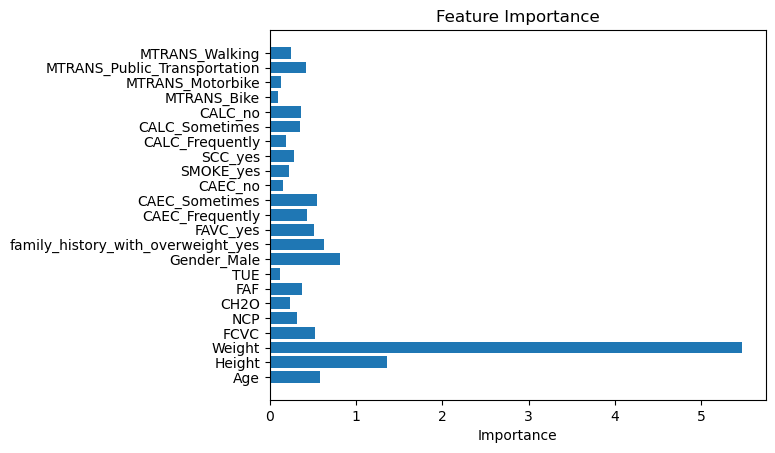

In [192]:
feature_importance_list = []

for estimator in model_ovo.estimators_:
    if hasattr(estimator, "coef_"):
        feature_importance_list.append(np.abs(estimator.coef_))
        
feature_importance = np.mean(np.vstack(feature_importance_list), axis=0)

plt.barh(X.columns, feature_importance)
plt.title("Feature Importance")
plt.xlabel("Importance")
plt.show()

In [140]:
list1=[]
for i in [0.1, 0.3, 0.25]:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=i, random_state=42, stratify=y)
    model_ovo = OneVsOneClassifier(LogisticRegression(max_iter=1000))
    model_ovo.fit(X_train, y_train)
    y_pred_ovo = model_ovo.predict(X_test)
    list1.append(np.round(100*accuracy_score(y_test, y_pred_ovo),2))

list1

[90.57, 90.85, 92.8]

In [210]:
def obesity_risk_pipeline(data_path, test_size):
    data = pd.read_csv(data_path)

    cont_col = data.select_dtypes(include=['float64']).columns.tolist()
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(data[cont_col])
    scaled_df = pd.DataFrame(scaled_features, columns=cont_col)
    scaled_data = pd.concat([data.drop(columns=cont_col), scaled_df], axis=1)
    
    cat_col = scaled_data.select_dtypes(include=['object']).columns.tolist()
    cat_col.remove('NObeyesdad')
    encoder = OneHotEncoder(sparse_output=False, drop='first')
    encoded_features = encoder.fit_transform(scaled_data[cat_col])
    encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(cat_col))
    prepped_data = pd.concat([scaled_data.drop(columns=cat_col), encoded_df], axis=1)
    
    prepped_data['NObeyesdad'] = prepped_data['NObeyesdad'].astype('category').cat.codes
    X = prepped_data.drop('NObeyesdad', axis=1)
    y = prepped_data['NObeyesdad']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    model = OneVsOneClassifier(LogisticRegression(max_iter=1000))
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print("Accuracy:", accuracy_score(y_test, y_pred))

obesity_risk_pipeline(file_path, test_size=0.2)

Accuracy: 0.9219858156028369


In [10]:
def plot_probability_array(X,probability_array):

    plot_array=np.zeros((X.shape[0],30))
    col_start=0
    ones=np.ones((X.shape[0],30))
    for class_,col_end in enumerate([10,20,30]):
        plot_array[:,col_start:col_end]= np.repeat(probability_array[:,class_].reshape(-1,1), 10,axis=1)
        col_start=col_end
    plt.imshow(plot_array)
    plt.xticks([])
    plt.ylabel("samples")
    plt.xlabel("probability of 3 classes")
    plt.colorbar()
    plt.show()

Text(0, 0.5, 'petal width')

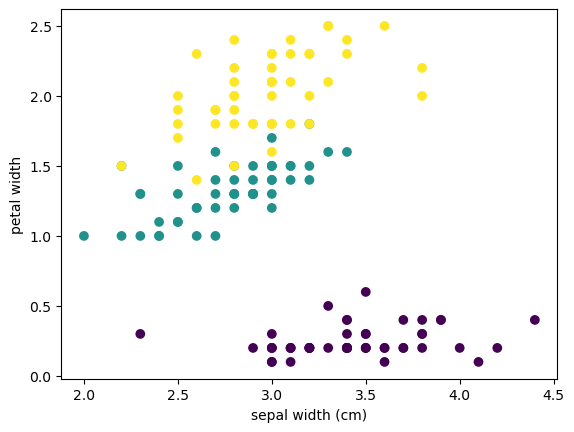

In [52]:
pair=[1, 3]
iris = datasets.load_iris()
X = iris.data[:, pair]
y = iris.target

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.viridis)
plt.xlabel("sepal width (cm)")
plt.ylabel("petal width")

In [68]:
def plot_decision_boundary_SVC(X, y, model):
    # Create a meshgrid over the feature space
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))
    
    # Predict on the grid points
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Plot the decision boundary
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.tab10)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor="k", cmap=plt.cm.tab10)
    plt.title("Decision Boundary")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.show()


In [54]:
model = SVC(kernel="linear", gamma=0.5, probability=True)
model.fit(X,y)
yhat = model.predict(X)
accuracy_score(y, yhat)

0.96

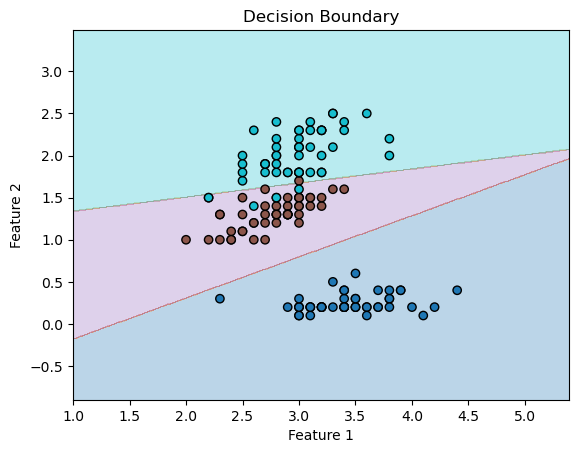

In [70]:
plot_decision_boundary_SVC(X,y,model)

In [96]:
# A helper function to plot the decision boundary
def plot_decision_boundary(X, y, classifier, ax, class_idx):
    # Meshgrid for decision boundary
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))
    Z = classifier.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Plot decision boundary
    ax.contourf(xx, yy, Z, alpha=0.3)
    ax.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', cmap=plt.cm.Paired)
    ax.set_title(f"Decision Boundary for Class {class_idx}")

In [98]:
ovr = OneVsRestClassifier(SVC(kernel='linear', gamma=0.5, probability=True))

ovr.fit(X, y)
probability = ovr.predict_proba(X)
ovr_arg = np.argmax(probability, axis=1)

print("Accuracy:", accuracy_score(y, ovr_arg))

Accuracy: 0.9466666666666667


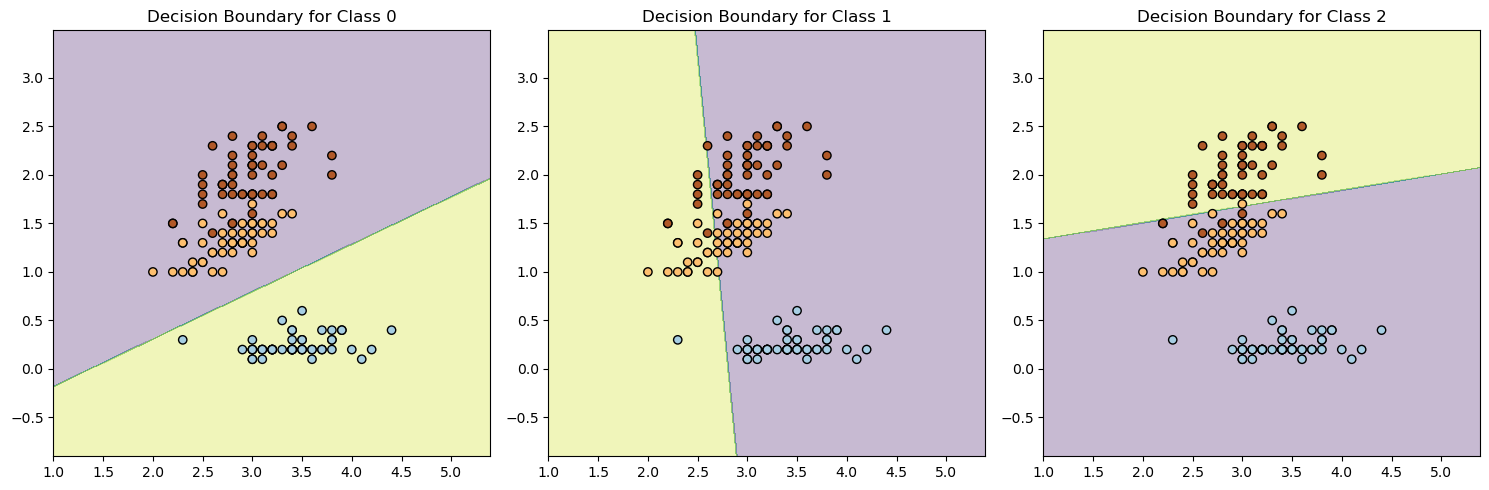

In [100]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, (model, ax) in enumerate(zip(ovr.estimators_, axes)):
    plot_decision_boundary(X, y, model, ax, class_idx=i)

plt.tight_layout()
plt.show()

In [83]:
ovo = OneVsOneClassifier(SVC(kernel='linear', gamma=0.5, probability=True))
ovo.fit(X, y)
pre = ovo.predict(X)
print("Accuracy:", accuracy_score(y, pre))

Accuracy: 0.96


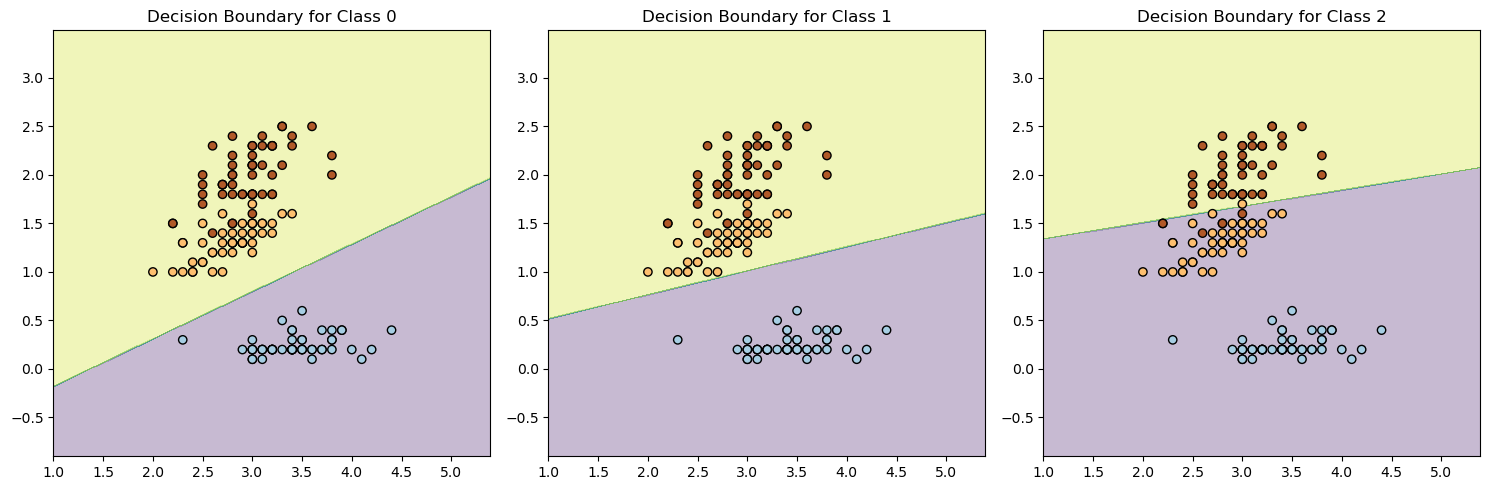

In [85]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, (model, ax) in enumerate(zip(ovo.estimators_, axes)):
    plot_decision_boundary(X, y, model, ax, class_idx=i)

plt.tight_layout()
plt.show()

In [109]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [127]:
param_grid = {'C': [0.1, 1, 10, 100],
              'gamma': [1, 0.1, 0.01, 0.001],
              'kernel': ['linear', 'rbf', 'poly']}
svc = SVC()

grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, scoring='accuracy', cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['linear', 'rbf', 'poly']},
             scoring='accuracy', verbose=2)

In [129]:
print("Best parameters found: ", grid_search.best_params_)
print("Best estimator: ", grid_search.best_estimator_)

Best parameters found:  {'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}
Best estimator:  SVC(C=0.1, gamma=1)


In [131]:
y_pred = grid_search.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30

